<a href="https://colab.research.google.com/github/Igorgodoi/tccpucminas/blob/master/TCCMINAS_Modelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Autor: Igor Reis de Godoi
# TCC PUCMINAS 2020 - Predição da duração de uma audiência trabalhista
# Quarta Parte: Criação de Modelos de Machine Learning

In [ ]:
from google.colab import drive
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
import numpy as np
import pandas as pd
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# Importando o dataset audiencias processada
drive.mount('/content/drive')
df_audiencia = pd.read_csv('/content/drive/My Drive/Colab Notebooks/datasets/audiencia_processada.csv', encoding='CP1252')
# Eliminando coluna municipio, pois é redundante com nome_municipio
df_audiencia=df_audiencia.drop(['municipio','Unnamed: 0','dt_inicio_programada','hora_abertura','hora_encerramento', 'data_audiencia' , 'dia_semana', 'minutos_do_dia'], axis=1)

Mounted at /content/drive


In [ ]:
# Ajustando tipagem de colunas
colunas_categoricas = ['uf_municipio', 'nome_municipio', 'tipo_audiencia', 'vara_trabalho', 'classe_processual', 'juiz', 'sala_audiencia', 
                       'atividade_economica', 'assunto', 'autor', 'reu','marcacao_automatica', 'apos_reforma_trabalhista', 'segredo_justica',
                       'justica_gratuita','tutela_liminar','prioridade']
for coluna in colunas_categoricas:
  df_audiencia[coluna] = df_audiencia[coluna].astype('category')


In [ ]:
# Importando bibliotecas 
from sklearn.tree import DecisionTreeRegressor,export_graphviz
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [ ]:
# Dividindo os dados em treino e teste:
X_train, X_test, y_train, y_test = train_test_split(df_audiencia.drop('duracao_audiencia',axis=1),df_audiencia['duracao_audiencia'],test_size=0.3, random_state=0)
df_audiencia_train=pd.concat([X_train,y_train], axis=1)
df_audiencia_test=pd.concat([X_test,y_test], axis=1)

In [ ]:
# Primeira predição, sem nenhum tratamento
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [ ]:
# Encoder Ordinal
!pip install category_encoders
from category_encoders.ordinal import OrdinalEncoder
enc = OrdinalEncoder(cols=colunas_categoricas)
enc.fit(df_audiencia_train)
df_audiencia_train_ord = enc.transform(df_audiencia_train)

In [ ]:
df_audiencia_test_ord = enc.transform(df_audiencia_test)
X_train_ord = df_audiencia_train_ord.drop("duracao_audiencia", axis=1)
X_test_ord = df_audiencia_test_ord.drop("duracao_audiencia", axis=1)

y_train_ord = df_audiencia_train_ord["duracao_audiencia"]
y_test_ord = df_audiencia_test_ord["duracao_audiencia"]

modelo_ord = RandomForestRegressor(n_jobs=6, n_estimators=100, random_state=22)
modelo_ord.fit(X_train_ord, y_train_ord)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=6, oob_score=False,
                      random_state=22, verbose=0, warm_start=False)

In [ ]:
predito_ord = modelo_ord.predict(X_test_ord)

In [ ]:
mean_absolute_error(y_test_ord, predito_ord)

7.575519007175916

In [ ]:
# Iniciando tuning hyperparametros. Primeiro ajustando min_samples_leaf=200
modelo_ord = RandomForestRegressor(n_jobs=6, n_estimators=100, random_state=22, min_samples_leaf=200)
modelo_ord.fit(X_train_ord, y_train_ord)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=200,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=6, oob_score=False,
                      random_state=22, verbose=0, warm_start=False)

In [ ]:
predito_ord = modelo_ord.predict(X_test_ord)
mean_absolute_error(y_test_ord, predito_ord)

7.186305981151011

In [ ]:
# tuning hiperparametros
from sklearn.model_selection import RandomizedSearchCV
modelo_ord.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 200,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 6,
 'oob_score': False,
 'random_state': 22,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# Número de árvores na floresta
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
# Features consideradas em cada split
max_features = ['auto', 'sqrt']
# Máximo número de níveis numa árvore
max_depth = [int(x) for x in np.linspace(10, 110, num = 6)]
max_depth.append(None)
# Mínimo número de exemplos num split de um nó 
min_samples_split = [2, 10, 50]
# Mínimo número de examplos em cada folha nó 
min_samples_leaf = [2, 5, 10, 40, 100, 200]
# Método de seleção de exemplos para treinar cada árvore
bootstrap = [True, False]
# Criando o grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
random_grid


{'bootstrap': [True, False],
 'max_depth': [10, 30, 50, 70, 90, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [2, 5, 10, 40, 100, 200],
 'min_samples_split': [2, 10, 50],
 'n_estimators': [200, 650, 1100, 1550, 2000]}

In [ ]:
# Criando o modelo para tuning 
rf = RandomForestRegressor()
# Procurando através de 30 combinações aleatórias 
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 30, cv = 2, verbose=2, random_state=22, n_jobs = 1)
# Aplicando o modelo 
rf_random.fit(X_train_ord, y_train_ord)

Fitting 2 folds for each of 30 candidates, totalling 60 fits
[CV] n_estimators=650, min_samples_split=10, min_samples_leaf=5, max_features=auto, max_depth=90, bootstrap=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=650, min_samples_split=10, min_samples_leaf=5, max_features=auto, max_depth=90, bootstrap=True, total= 8.0min
[CV] n_estimators=650, min_samples_split=10, min_samples_leaf=5, max_features=auto, max_depth=90, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.0min remaining:    0.0s


[CV]  n_estimators=650, min_samples_split=10, min_samples_leaf=5, max_features=auto, max_depth=90, bootstrap=True, total= 8.0min
[CV] n_estimators=1550, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=70, bootstrap=False 
[CV]  n_estimators=1550, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=70, bootstrap=False, total= 6.8min
[CV] n_estimators=1550, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=70, bootstrap=False 
[CV]  n_estimators=1550, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=70, bootstrap=False, total= 6.9min
[CV] n_estimators=650, min_samples_split=2, min_samples_leaf=40, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=650, min_samples_split=2, min_samples_leaf=40, max_features=sqrt, max_depth=10, bootstrap=True, total= 1.2min
[CV] n_estimators=650, min_samples_split=2, min_samples_leaf=40, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimato

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 542.5min finished


RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [ ]:
rf_random.best_params_

{'bootstrap': False,
 'max_depth': 70,
 'max_features': 'sqrt',
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 1550}

In [ ]:
# Setando os hiperparametros tunados
mdlTunado = RandomForestRegressor(n_jobs=6, n_estimators=650, random_state=22, min_samples_leaf=4, min_samples_split=10, max_features='sqrt', max_depth=70 )
mdlTunado.fit(X_train_ord, y_train_ord)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=70, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=650, n_jobs=6, oob_score=False,
                      random_state=22, verbose=0, warm_start=False)

In [ ]:
preditoTunado = mdlTunado.predict(X_test_ord)
mean_absolute_error(y_test_ord, preditoTunado)

7.169625897006572

In [ ]:
# Encoding atributos categóricos
from category_encoders.target_encoder import TargetEncoder

In [ ]:
enc = TargetEncoder(cols=colunas_categoricas, min_samples_leaf=200)
enc.fit(df_audiencia_train, df_audiencia_train['duracao_audiencia'])
df_audiencia_train_trg = enc.transform(df_audiencia_train)
df_audiencia_test_trg = enc.transform(df_audiencia_test)


In [ ]:
X_train_trg = df_audiencia_train_trg.drop("duracao_audiencia", axis=1)
X_test_trg = df_audiencia_test_trg.drop("duracao_audiencia", axis=1)

y_train_trg = df_audiencia_train_trg["duracao_audiencia"]
y_test_trg = df_audiencia_test_trg["duracao_audiencia"]

mdl_trg = RandomForestRegressor(n_jobs=6, n_estimators=650, random_state=22, min_samples_leaf=4, min_samples_split=10, max_features='sqrt', max_depth=70)
mdl_trg.fit(X_train_trg, y_train_trg)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=70, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=650, n_jobs=6, oob_score=False,
                      random_state=22, verbose=0, warm_start=False)

In [ ]:
p_trg = mdl.predict(X_test_trg)
mean_absolute_error(y_test_trg, p_trg)

8.658679100927053

In [ ]:
mdlTunado.feature_importances_

array([0.00105663, 0.02514018, 0.02623164, 0.4384904 , 0.04140917,
       0.01491285, 0.04819348, 0.00447404, 0.04547821, 0.01239985,
       0.07253317, 0.00084348, 0.00630877, 0.00342861, 0.00246069,
       0.05030236, 0.04991529, 0.07453193, 0.08188925])

Feature: 0, Score: 0.00106
Feature: 1, Score: 0.02514
Feature: 2, Score: 0.02623
Feature: 3, Score: 0.43849
Feature: 4, Score: 0.04141
Feature: 5, Score: 0.01491
Feature: 6, Score: 0.04819
Feature: 7, Score: 0.00447
Feature: 8, Score: 0.04548
Feature: 9, Score: 0.01240
Feature: 10, Score: 0.07253
Feature: 11, Score: 0.00084
Feature: 12, Score: 0.00631
Feature: 13, Score: 0.00343
Feature: 14, Score: 0.00246
Feature: 15, Score: 0.05030
Feature: 16, Score: 0.04992
Feature: 17, Score: 0.07453
Feature: 18, Score: 0.08189


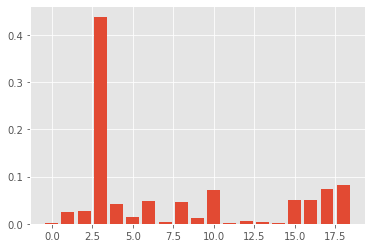

In [ ]:
importancia = mdlTunado.feature_importances_
# summarize feature importance
for i,v in enumerate(importancia):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importancia))], importancia)
pyplot.show()

In [ ]:
feature_importances = pd.DataFrame(mdlTunado.feature_importances_,
                                   index = X_train_trg.columns,
                                   columns=['importancia']).sort_values('importancia', ascending=False)

In [ ]:
feature_importances

,importancia
tipo_audiencia,0.438490
reu,0.081889
autor,0.074532
valor_causa,0.072533
atividade_economica,0.050302
assunto,0.049915
juiz,0.048193
sala_audiencia,0.045478
vara_trabalho,0.041409
populacao_estimada2019_municipio,0.026232


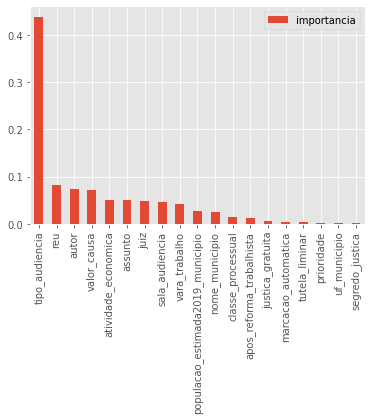

In [ ]:
feature_importances.plot(kind='bar')

In [ ]:
# Eliminado colunas com pouca importância, uma a uma na ordem inversa de importância. Determinando qual é a melhor.
colunas_eliminar=['reu','autor','valor_causa','atividade_economica','assunto', 'juiz', 'sala_audiencia', 'vara_trabalho', 
                  'populacao_estimada2019_municipio', 'nome_municipio', 'classe_processual', 'apos_reforma_trabalhista', 
                  'segredo_justica','uf_municipio','prioridade','tutela_liminar','marcacao_automatica','justica_gratuita']


In [ ]:
X_train_ord2=X_train_ord.copy()
X_test_ord2=X_test_ord.copy()

for coluna in reversed(colunas_eliminar):
  X_train_ord2=X_train_ord2.drop(columns=coluna, axis=1)
  X_test_ord2=X_test_ord2.drop(columns=coluna, axis=1)
  mdlTunado2 = RandomForestRegressor(n_jobs=6, n_estimators=650, random_state=22, min_samples_leaf=4, min_samples_split=10, max_features='sqrt', max_depth=70 )
  mdlTunado2.fit(X_train_ord2, y_train_ord)
  preditoTunado2 = mdlTunado2.predict(X_test_ord2)
  mae=mean_absolute_error(y_test_ord, preditoTunado2)
  print("Coluna Eliminada: {} - MAE = {}".format(coluna,mae))
  

Coluna Eliminada: justica_gratuita - MAE = 7.171722174824094
Coluna Eliminada: marcacao_automatica - MAE = 7.177781344017157
Coluna Eliminada: tutela_liminar - MAE = 7.167213760992077
Coluna Eliminada: prioridade - MAE = 7.209926282314803
Coluna Eliminada: uf_municipio - MAE = 7.198579671777153
Coluna Eliminada: segredo_justica - MAE = 7.1852208279657015
Coluna Eliminada: apos_reforma_trabalhista - MAE = 7.16534593195975
Coluna Eliminada: classe_processual - MAE = 7.204032138118465
Coluna Eliminada: nome_municipio - MAE = 7.203338744214399
Coluna Eliminada: populacao_estimada2019_municipio - MAE = 7.214975124249408
Coluna Eliminada: vara_trabalho - MAE = 7.281340991465531
Coluna Eliminada: sala_audiencia - MAE = 7.273126372888983
Coluna Eliminada: juiz - MAE = 7.302571581520042
Coluna Eliminada: assunto - MAE = 7.307172551307031
Coluna Eliminada: atividade_economica - MAE = 7.3151596160841175
Coluna Eliminada: valor_causa - MAE = 7.429997873191814
Coluna Eliminada: autor - MAE = 7.3367

In [ ]:
# Eliminando as 3 piores colunas apresentou um resultado melhor. Refazendo
colunas_eliminar=['tutela_liminar','marcacao_automatica','justica_gratuita']
X_train_ord2=X_train_ord.drop(columns=colunas_eliminar)
X_test_ord2=X_test_ord.drop(columns=colunas_eliminar)

mdlTunado2 = RandomForestRegressor(n_jobs=6, n_estimators=650, random_state=22, min_samples_leaf=4, min_samples_split=10, max_features='sqrt', max_depth=70 )
mdlTunado2.fit(X_train_ord2, y_train_ord)
preditoTunado2 = mdlTunado2.predict(X_test_ord2)
mae=mean_absolute_error(y_test_ord, preditoTunado2)
print("Coluna Eliminada: {} - MAE = {}".format(coluna,mae))



Coluna Eliminada: reu - MAE = 7.167213760992077


In [ ]:
mdlTunado2 = RandomForestRegressor(n_jobs=6, n_estimators=650, random_state=22, min_samples_leaf=4, min_samples_split=10, max_features='sqrt', max_depth=70 )
mdlTunado2.fit(X_train_ord2, y_train_ord)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=70, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=650, n_jobs=6, oob_score=False,
                      random_state=22, verbose=0, warm_start=False)

In [ ]:
preditoTunado2 = mdlTunado2.predict(X_test_ord2)
mean_absolute_error(y_test_ord, preditoTunado2)

7.162986411739751

In [ ]:
# Usando algoritimo GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
regressor = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=22)
regressor.fit(X_train_ord, y_train_ord)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=22, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
from sklearn.metrics import mean_squared_error
errors = [mean_squared_error(y_test_ord, y_pred) for y_pred in regressor.staged_predict(X_test_ord)]
best_n_estimators = np.argmin(errors)

In [ ]:
best_n_estimators

2

In [ ]:
regressor = GradientBoostingRegressor(max_depth=2, n_estimators=best_n_estimators, learning_rate=1.0, random_state=22)
regressor.fit(X_train_ord, y_train_ord)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=2,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=22, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
predito = regressor.predict(X_test_ord)
mean_absolute_error(y_test_ord, predito)

7.520213456072019

In [ ]:
# Testando XGBOOST Regression
import xgboost as xgb

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10, random_state=22)

In [ ]:
xg_reg.fit(X_train_ord, y_train_ord)
predito = xg_reg.predict(X_test_ord)
mean_absolute_error(y_test_ord, predito)

7.864296313580353